# Trash Sorting the Right wAI

## 1. Overview:<a name="1"></a>

#### 1.1 Team:
- Emma
- Raphael

#### 1.2 Topic:
**Garbage Image Classification**
##### 1.2.1 Objective:
- Train model to classify different types of garbage (recycable, non-recycable) 
    - Using pretrained resnet18

##### 1.2.2 Data:
Collected by Gary Thung and Mindy Yang.
The Dataset contains 2527 images of six classes of garbage deployed on plain background:
 - 501 glass
 - 594 paper
 - 403 cardboard
 - 482 plastic
 - 410 metal
 - 137 trash


##### 1.2.3 Link to the Dataset:
https://github.com/garythung/trashnet/blob/master/data/dataset-resized.zip

#### 1.3 Table of contents:<a name="index"></a>
1. [Overview](#1) <br>
2. [Import libraries](#2) <br>
3. [Load data](#3) <br>
    3.1 [Load, transform and split data](#3.1) <br>
    3.2 [Visualise transformed images](#3.2) <br>
4. [Load Model](#4) <br>
5. [Model Training](#5) <br>
    5.1 [Set tuning parameters](#5.1) <br>
    5.2 [Create training loop](#5.2) <br>
    5.3 [Rund training loop](#5.3) <br>
6. [Visualise model predictions](#6) <br>
    6.1 [Predict class probabilites for one image](#6.1) <br>
    6.2 [Predict labels for folder of images](#6.2) <br>
7. [Evaluate Model](#7) <br>

## 2. Import libraries <a name="2"></a>
Import necessary libraries for data-handling, plotting, modeling.
[↑ back to top ↑](#index)

In [32]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torchvision
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange, tqdm
import pickle
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 3. Load data <a name="3"></a>
[↑ back to top ↑](#index)

#### 3.1 Load, transform and split the data:<a name="3.1"></a>

Original image-size = 512x384 <br>
Model Imput size = 224x224 <br>
Set up transfomer: Resized to 224 (shorter side). Cropped to 224x224. Random horizonatlFlip. Stored as tensor.


In [33]:
data_transformer = transforms.Compose([transforms.Resize(224),
                                       transforms.CenterCrop(224), 
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                        ])

Set up split function for relative train/test/val split

In [34]:
def get_80_20_split(data_set, rel):
    
    set80 = int(rel * len(data_set))
    set20 = len(data_set) - set80
    
    return [set80, set20] 

Train/Test/Val split and loader set up

In [35]:
data_set = datasets.ImageFolder(root='data/dataset-resized', transform=data_transformer)

train_set, test_set = torch.utils.data.random_split(data_set, get_80_20_split(data_set, rel = 0.8))
train_set, val_set = torch.utils.data.random_split(train_set, get_80_20_split(train_set, rel = 0.8))

loader_train = torch.utils.data.DataLoader(train_set, batch_size=32, shuffle=True)
loader_val = torch.utils.data.DataLoader(val_set, batch_size=8, shuffle=True)
loader_test = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=True)

# original classes (labels)
classes = data_set.classes

In [36]:
# test_set saved for demo
with open("data/test_set.pickle",'wb') as fp:
    pickle.dump(test_set, fp)

#### 3.2 Visualise transformed images<a name="3.2"></a>

In [37]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(16,16))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
images, labels = next(iter(loader_train))

labels:  ['paper', 'plastic', 'plastic', 'metal', 'glass', 'paper', 'paper', 'plastic', 'paper', 'glass', 'metal', 'paper', 'metal', 'plastic', 'plastic', 'plastic', 'paper', 'paper', 'paper', 'metal', 'cardboard', 'glass', 'cardboard', 'plastic', 'metal', 'trash', 'metal', 'glass', 'metal', 'glass', 'metal', 'paper']


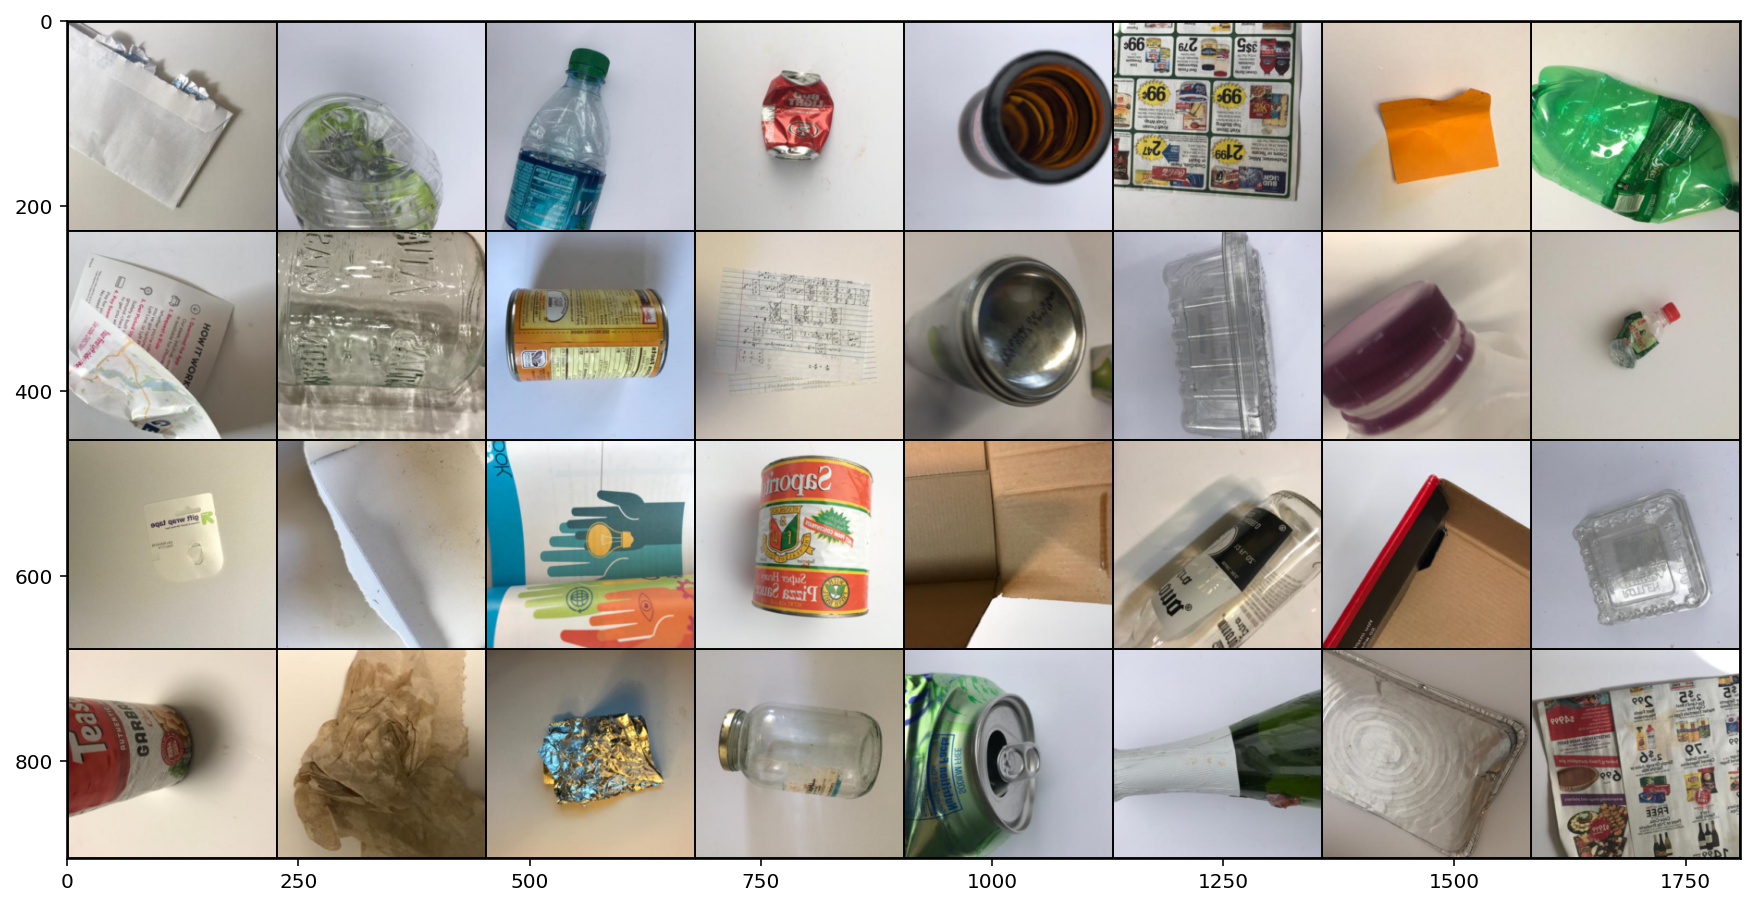

In [38]:
grid = torchvision.utils.make_grid(images, nrow=8)

plt.figure(figsize=(15, 15))
plt.imshow(np.transpose(grid, (1, 2, 0)))

print('labels: ', [classes[x] for x in labels])

## 4. Load model <a name="4"></a>
We use pretrained resnet18 model. [Resnet18](https://arxiv.org/pdf/1512.03385.pdf) is a convolutional neural network (CNN) with 18 layers. Pretraining on [ImageNet](https://image-net.org/) database. <br> 
[↑ back to top ↑](#index)

Load model or create new if not existing

In [39]:
model_name = 'resnet18_v3'
model_path = "model/" + str(model_name) + ".pickle"

In [40]:
try:
    with open(model_path,'rb') as fp:
        model = pickle.load(fp)
    print(f"Model '{model_name}' loaded from file:", model_path)
except:
    print("Couldn't find model. Created new resnet18-model.")
    model = models.resnet18(pretrained=True)

Model 'resnet18_v3' loaded from file: model/resnet18_v3.pickle


## 5. Model Training <a name="5"></a>
Setup optimiser function and training loop. Stochastic gradient descent (SGD) is used. The training loop loads minibatches via the dataloader (loader_train), calculates losses via cross entropy and adjust the weights via step(). At the same time the validation loss is calculated. A list for each loss per batch is returned.<br>
[↑ back to top ↑](#index)

### 5.1 Set tuning parameters and optimiser<a name="5.1"></a>

In [41]:
# set tuning parameters
learn_rate = 1e-4
epochs = 0 #set to 0 for not training

In [42]:
optimiser = torch.optim.SGD(model.parameters(), lr=learn_rate)

### 5.2 Create training loop<a name="5.2"></a>
One loop of training. Returns training and validation losses.

In [43]:
def training_loop(loader_train, loader_val, model, optimiser):
    
    #total_loss = 0
    total_loss = []
    total_val_loss = []

    for batch, (images, labels) in enumerate(loader_train):
        
        model.train()

        pred = model(images)
        loss = nn.functional.cross_entropy(pred, labels)
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        with torch.no_grad():

            images, labels = next(iter(loader_val))
            model.eval()
            val_pred = model(images)
            val_loss = nn.functional.cross_entropy(val_pred, labels)

        # print(f"Batch {batch + 1} training loss: {loss} validation loss: {val_loss}") 

        # total_loss += loss.item()
        total_loss.append(loss.item())
        total_val_loss.append(val_loss.item())
    
  #  print(f"Accumulated loss: {total_loss}") 

    return total_loss, total_val_loss
    

Loss table for documentaion of evolution of losses over epochs

In [44]:
loss_table_path = "model/training_losses_" + str(model_name) + ".csv"
try:
    loss_df = pd.read_csv(loss_table_path, index_col = False)
    print("Loss table loaded from csv. Epochs run:", len(loss_df))
except:
    loss_df = pd.DataFrame({"Epoch":[],
                        "Training loss":[],
                        "Validation loss":[]
                        })
    print("Failed to load loss table from csv. Created new one.")

Loss table loaded from csv. Epochs run: 50


### 5.3 Run training loop - epochs<a name="5.3"></a>
Model saved as pickle. Loss table saved to csv.

In [45]:
for i in range(epochs):

    total_loss, val_loss = training_loop(loader_train, loader_val, model, optimiser)

    avg_loss =  sum(total_loss)/len(total_loss)
    avg_val = sum(val_loss)/len(val_loss)

    # store losses per epoch in df to save as csv for visualisation in presentation
    loss_df = loss_df.append(pd.DataFrame({"Epoch":[int(len(loss_df)+1)],
                                        "Training loss":[avg_loss],
                                        "Validation loss":[avg_val]}),ignore_index=True)

    
    with open(model_path,'wb') as fp:
        pickle.dump(model, fp)

loss_df.to_csv(loss_table_path,index=False)

loss_df

Epoch  Training loss  Validation loss
0     1.0       9.830496        10.178691
1     2.0       9.159052         9.375701
2     3.0       8.490000         8.704576
3     4.0       7.807452         7.971934
4     5.0       7.177356         7.297019
5     6.0       6.506975         6.632872
6     7.0       5.891487         5.973722
7     8.0       5.280076         5.364810
8     9.0       4.732299         4.804628
9    10.0       4.249138         4.321951
10   11.0       3.821093         3.834750
11   12.0       3.475515         3.474680
12   13.0       3.089034         3.118647
13   14.0       2.831026         2.824025
14   15.0       2.557806         2.499118
15   16.0       2.314503         2.310769
16   17.0       2.124995         2.078325
17   18.0       1.978415         1.921063
18   19.0       1.841334         1.802287
19   20.0       1.715660         1.646037
20   21.0       1.602427         1.557140
21   22.0       1.348858         1.290614
22   23.0       0.941886         0.802686
23   24.0       0.741005         0.627617
24   25.0       0.633111         0.504662
25   26.0       0.531512         0.395364
26   27.0       0.464919         0.340738
27   28.0       0.417760         0.293286
28   29.0       0.377830         0.263130
29   30.0       0.328433         0.227507
30   31.0       0.298653         0.209484
31   32.0       0.250936         0.176121
32   33.0       0.261461         0.163460
33   34.0       0.234514         0.145110
34   35.0       0.211715         0.124314
35   36.0       0.279450         0.310827
36   37.0       0.274116         0.285752
37   38.0       0.261373         0.260251
38   39.0       0.242876         0.326949
39   40.0       0.225033         0.317374
40   41.0       0.228516         0.196689
41   42.0       0.213018         0.256217
42   43.0       0.204930         0.324841
43   44.0       0.205035         0.301528
44   45.0       0.179736         0.231164
45   46.0       0.164930         0.249097
46   47.0       0.181042         0.252721
47   48.0       0.179475         0.309349
48   49.0       0.164548         0.220867
49   50.0       0.168561         0.220994

## 6. Visualise model predictions <a name="6"></a>
[↑ back to top ↑](#index)

### 6.1 Predict class probabilities for single image<a name="6.1"></a>
Load test-image and run model for classification. Gives probabilities for all classes.<br>


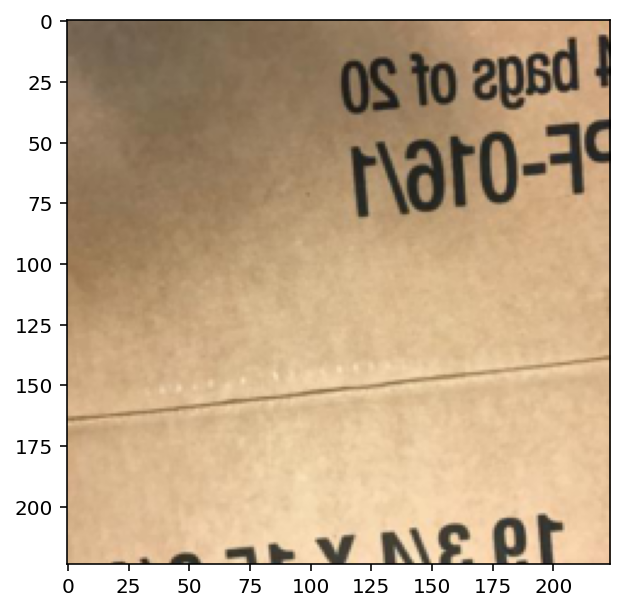

True label: cardboard
Predicted label: cardboard

Predicted probabilities:
99.79 %        cardboard
0.0 %        glass
0.0 %        metal
0.0 %        paper
0.0 %        plastic
0.0 %        trash


In [46]:
images, labels = next(iter(loader_test))
grid = torchvision.utils.make_grid(images, nrow=8)

with torch.no_grad():
    
    images_pred = model(images)
    pred_label = np.argmax(images_pred)
    prob = torch.softmax(images_pred, dim=1)

plt.figure(figsize=(5, 5))
plt.imshow(np.transpose(grid, (1, 2, 0)))
plt.show()

print("True label:", classes[int(labels)])
print("Predicted label:", classes[int(pred_label)])
print()
print("Predicted probabilities:")

    
for i in range(6):
    print( round(float(prob[0][i])*100, 2), "%       ",classes[i])


### 6.2 Predict labels for folder of images<a name="6.2"></a>
Load set of images and run model for classification. Gives correct bin for garbage on image.<br>

In [47]:
folder_path = 'data/demonstrate/'

In [48]:
def show(folder_path, batch_size):

    demo_set = datasets.ImageFolder(root=folder_path, transform=data_transformer)
    loader_demo = torch.utils.data.DataLoader(demo_set, batch_size=batch_size, shuffle=False)
    bins = ["paper bin", "glass container", "recycling bin", "paper bin", "recycling bin", "trash bin"]

    for batch, (images,labels) in enumerate(loader_demo):

        with torch.no_grad():         
            outputs = model(images)
                
        fix, axs = plt.subplots(ncols=len(images), squeeze=False, figsize=(24,4))

        
        for i, img in enumerate(images):
            
            try:
                pred_label = "Predicted: "+ classes[int(np.argmax(outputs[i]))]
                pred_bin = "Please put in " + bins[int(np.argmax(outputs[i]))]
            except:
                pred_label = "Couldn't predict"
                pred_bin = "Please put in " + bins[5]
            
            img = img.detach()
            img = TF.to_pil_image(img)
            axs[0, i].imshow(np.asarray(img))
            axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], title=pred_label, xlabel = pred_bin)

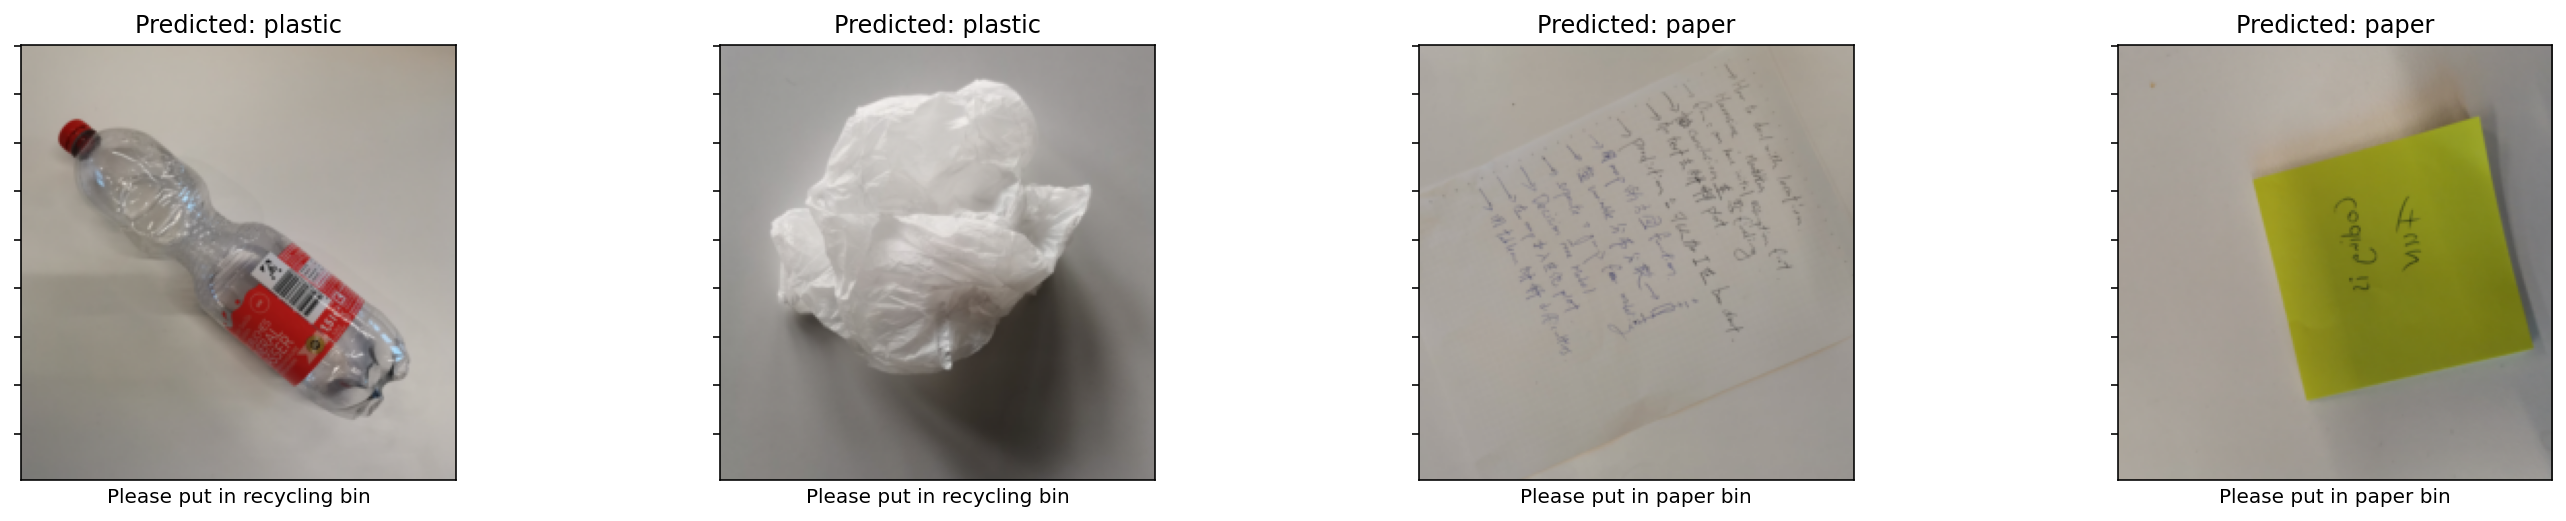

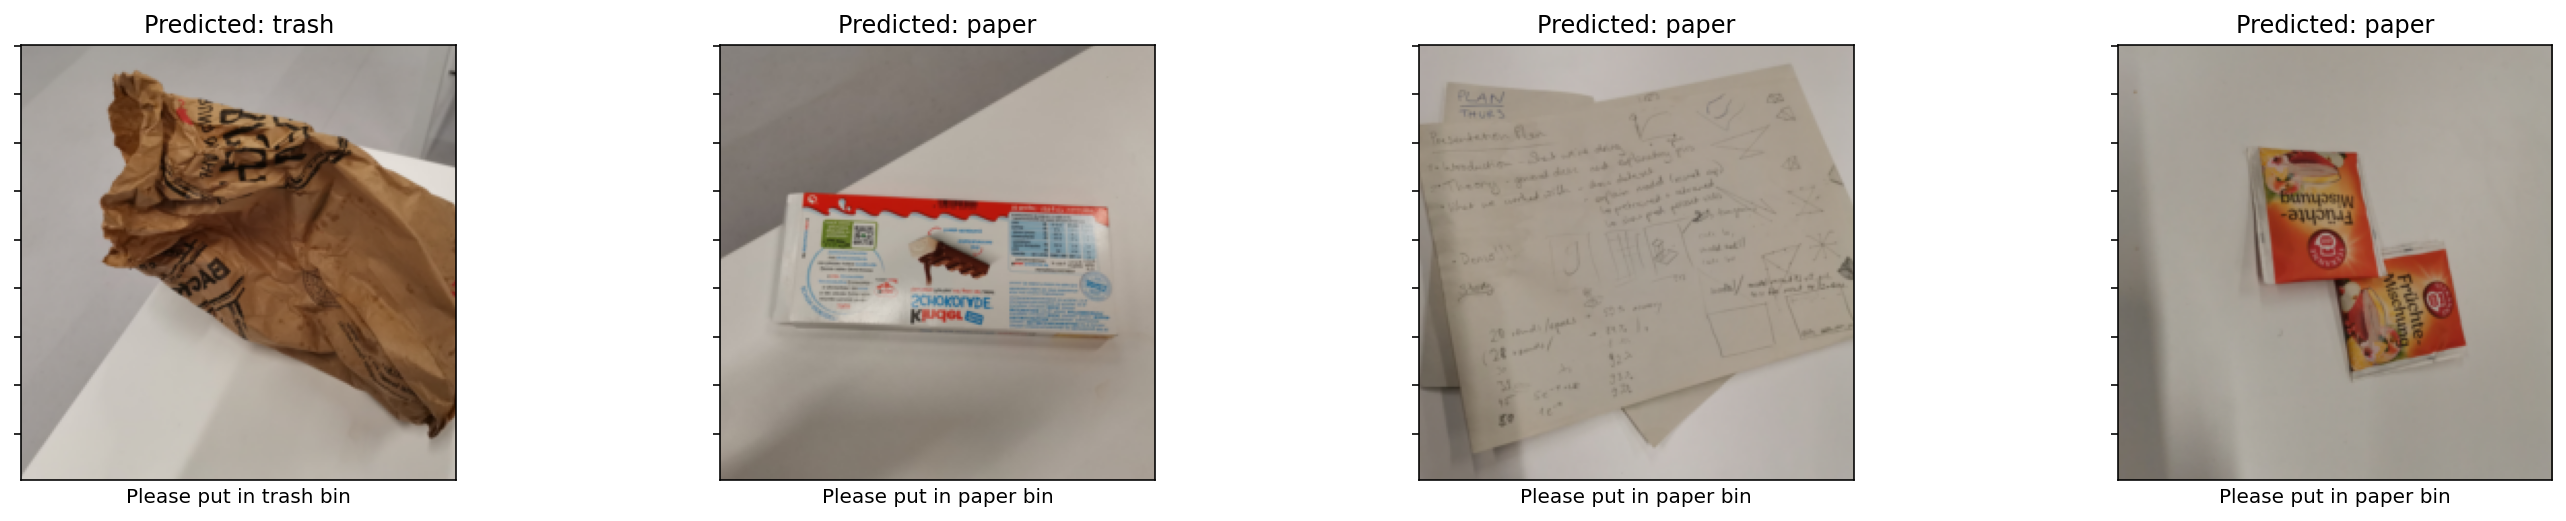

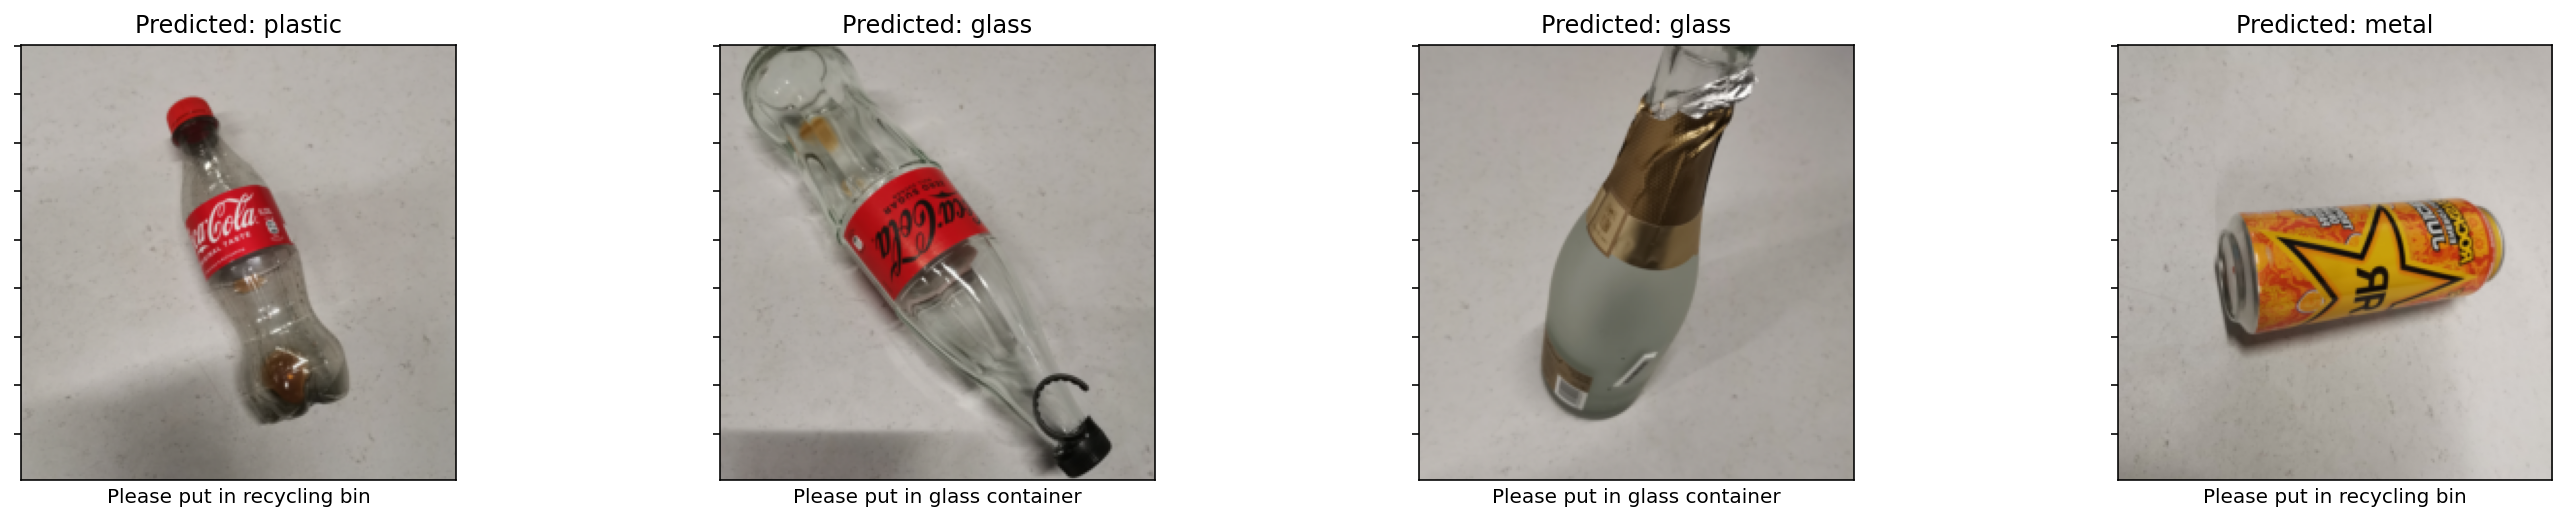

In [49]:
    show(folder_path, 4)

## 7. Evaluate Model<a name="7"></a>
Calculate accuracy and plot cofusion matrix for test-set.<br>
[↑ back to top ↑](#index)

In [50]:
# with open('model/model_path','rb') as fp:
#     model = pickle.load(fp)

506it [00:40, 12.43it/s]


Accuracy of the model on the test-set: 96 %


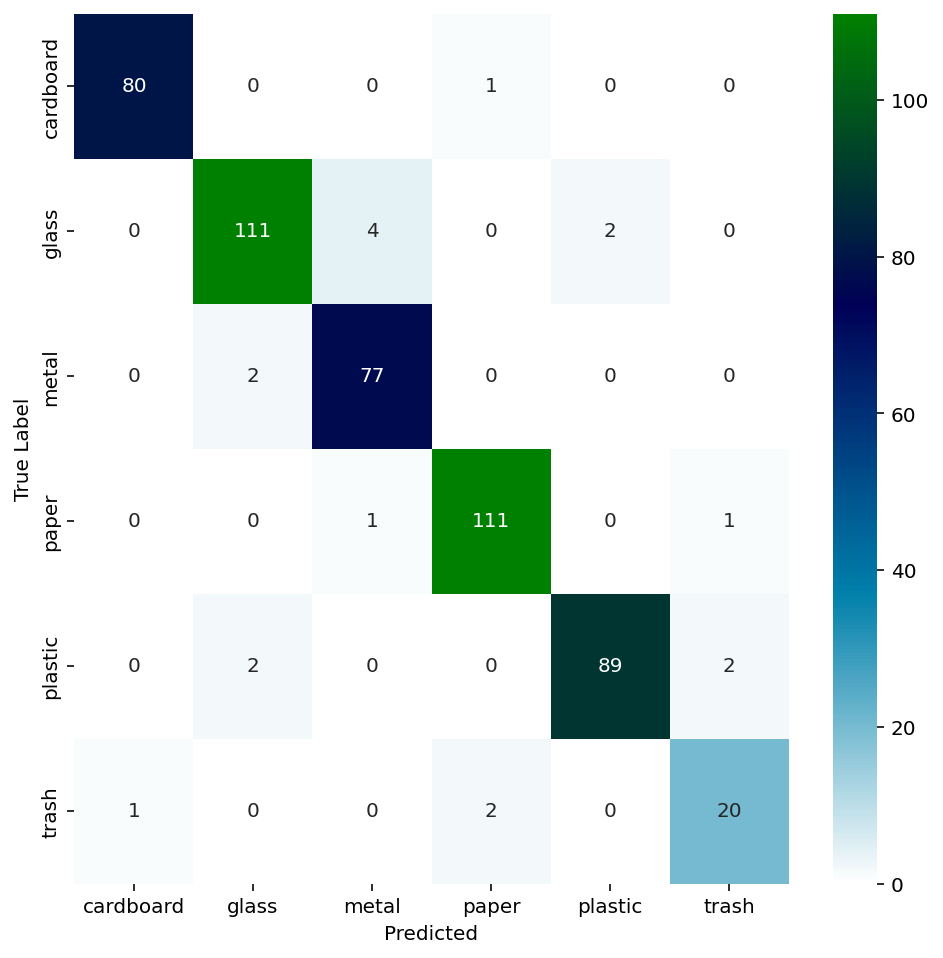

In [51]:
with torch.no_grad():

    correct = 0
    total = 0
    predicted_label = []
    label = []

    for batch, (images, labels) in tqdm(enumerate(loader_test)):
        outputs = model(images)
        predicted = np.argmax(outputs)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        class_label = classes[int(labels)]
        pred_label = classes[int(predicted)]

        label.append(class_label)
        predicted_label.append(pred_label)

    con_matr = confusion_matrix(label, predicted_label)

print('Accuracy of the model on the test-set: %d %%' % (100 * correct / total))

df_con_matr = pd.DataFrame(con_matr, classes, classes)
plt.figure(figsize = (8,8))
sns.heatmap(df_con_matr, annot= True, fmt="d", cmap="ocean_r")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.show()

1616it [02:54,  9.24it/s]


Accuracy of the model on the train-set: 97 %


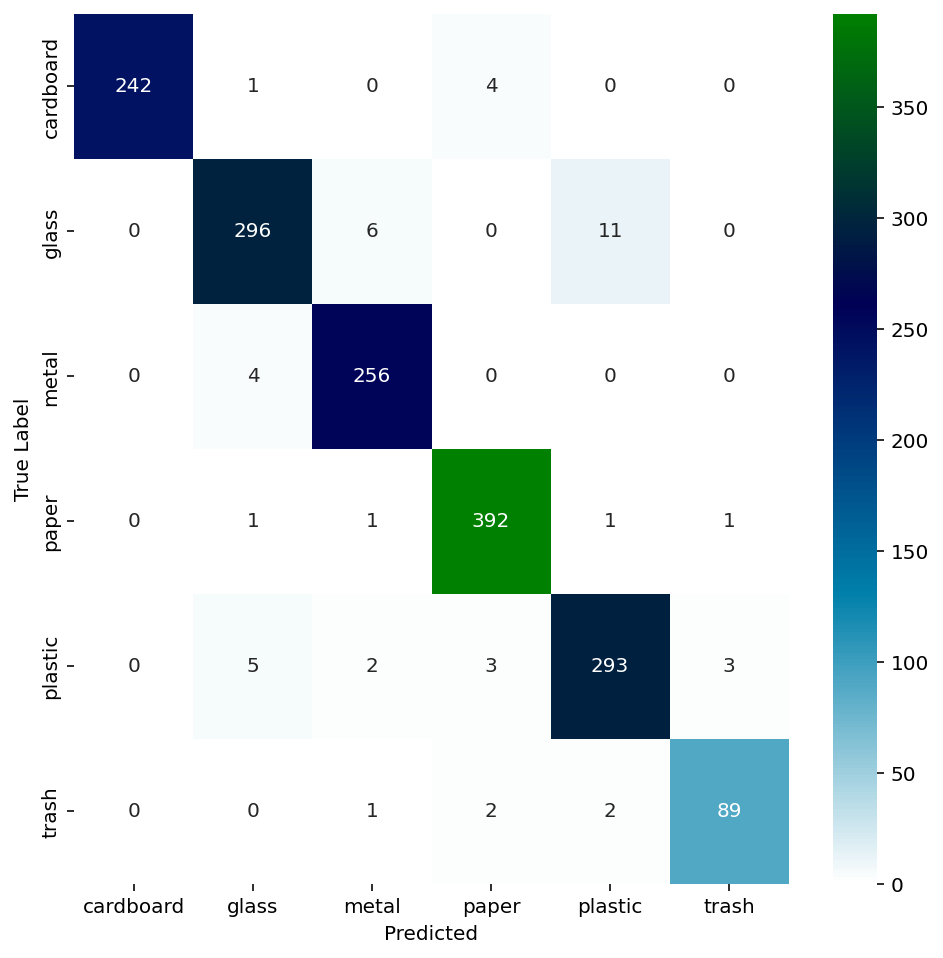

In [52]:
loader_train = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)

with torch.no_grad():

    correct = 0
    total = 0
    predicted_label = []
    label = []

    for batch, (images, labels) in tqdm(enumerate(loader_train)):
        outputs = model(images)
        predicted = np.argmax(outputs)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        class_label = classes[int(labels)]
        pred_label = classes[int(predicted)]

        label.append(class_label)
        predicted_label.append(pred_label)

    con_matr = confusion_matrix(label, predicted_label)

print('Accuracy of the model on the train-set: %d %%' % (100 * correct / total))

df_con_matr = pd.DataFrame(con_matr, classes, classes)
plt.figure(figsize = (8,8))
sns.heatmap(df_con_matr, annot= True, fmt="d", cmap="ocean_r")
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.show()